In [134]:
import seaborn
import numpy as np
import sys
import pandas as pd

from pandas import read_csv
from pandas import set_option
from matplotlib import pyplot
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [118]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = pyplot.subplots( figsize =( 14 , 12 ) )
    cmap = seaborn.diverging_palette( 220 , 10 , as_cmap = True )
    _ = seaborn.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
plot_correlation_map(df_wines)    

In [52]:
df_wines = pd.read_csv('./data/wine/winemag-data-130k-v2.csv')

In [53]:
# dimension de la matriz de vinos
df_wines.shape

(129971, 14)

In [54]:
# primer registro del set de datos
df_wines.head(1)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


# ANALISIS EXPLORATORIO

In [84]:
# cantidad de vinos por pais
df_wines.country.count()
#df_wines_argentina = df_wines[df_wines['country']=='Argentina']
#df_wines_argentina.size
apc['Operator'].value_counts()

129908

In [88]:
print('existen registros sin pais: ',df_wines['country'].isnull().any())
print('existen registros sin descripcion: ',df_wines['description'].isnull().any())

('existen registros sin pais: ', True)
('existen registros sin descripcion: ', False)


In [109]:

print('total de resgistros: ', df_wines.shape[0])
print('registros con paises nulos: ',df_wines[df_wines['country'].isnull()].shape[0])
print('registros con vinedos nulos: ',df_wines[df_wines['winery'].isnull()].shape[0])

('total de resgistros: ', 129971)
('registros con paises nulos: ', 63)
('registros con vinedos nulos: ', 0)


In [103]:
# cantidad de registros por pais
qty_by_country = df_wines[df_wines['country'].notnull()]['country'].value_counts()

In [104]:
qty_by_winery = df_wines[df_wines['winery'].notnull()]['winery'].value_counts()

In [119]:
qty_by_country.head(10)

US           54504
France       22093
Italy        19540
Spain         6645
Portugal      5691
Chile         4472
Argentina     3800
Austria       3345
Australia     2329
Germany       2165
Name: country, dtype: int64

In [110]:
qty_by_winery.head(10)

Wines & Winemakers       222
Testarossa               218
DFJ Vinhos               215
Williams Selyem          211
Louis Latour             199
Georges Duboeuf          196
Chateau Ste. Michelle    194
Concha y Toro            164
Columbia Crest           159
Kendall-Jackson          130
Name: winery, dtype: int64

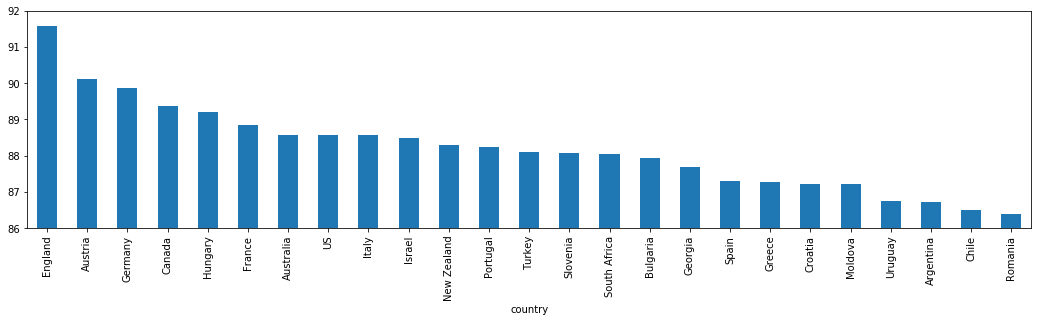

In [148]:
# los mejores puntajes proedio por pais, para aquellos que tengan mas de 50
fr = df_wines.groupby('country').agg(['mean','count'])
fr.loc[fr[('points','count')]>50][('points','mean')].sort_values(ascending=False)[0:25].plot(kind='bar',figsize=(18,4),ylim=(86,92));

In [145]:
fr.loc[fr[('points','count')]>50][('points','mean')].sort_values(ascending=False)[0:25]

country
England         91.581081
Austria         90.101345
Germany         89.851732
Canada          89.369650
Hungary         89.191781
France          88.845109
Australia       88.580507
US              88.563720
Italy           88.562231
Israel          88.471287
New Zealand     88.303030
Portugal        88.250220
Turkey          88.088889
Slovenia        88.068966
South Africa    88.056388
Bulgaria        87.936170
Georgia         87.686047
Spain           87.288337
Greece          87.283262
Croatia         87.219178
Moldova         87.203390
Uruguay         86.752294
Argentina       86.710263
Chile           86.493515
Romania         86.400000
Name: (points, mean), dtype: float64

In [57]:
#cantidad de variedades de vinos (708)
df_wines.variety.unique().size

708

# SISTEMA DE CLASIFICACIÓN

In [58]:
# extraemos columna de variedad y de descripcion
df_wines_variety = df_wines.iloc[:,12:13]
df_wines_description = df_wines.iloc[:,2:3]

In [59]:
# generamos un indice permutado, el cual genera el efecto de mezclar el set de datos
# luego generamos el set de train y de test de los textos y de las variedades a clasificar

np.random.seed(0)
indices_variedad = np.random.permutation(len(df_wines))
len(indices_variedad)
wine_train_description = df_wines_description.iloc[indices_variedad[0:100000]]
wine_train_variety = df_wines_variety.iloc[indices_variedad[0:100000]]
wine_test_description = df_wines_description.iloc[indices_variedad[100000:129971]]
wine_test_variety = df_wines_variety.iloc[indices_variedad[100000:129971]]

In [60]:
# utiliamos el contador de palabra y luego calculamos el term frecuency
# con esto procesamos los textos del set de train y de test
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(wine_train_description.description)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

X_test_counts = count_vect.transform(wine_test_description.description)
X_test_tf = tf_transformer.transform(X_test_counts)

In [79]:
# usamos el modelo Multinomial Nayve Bayes
# y vemos la precision
clf_MNB = MultinomialNB().fit(X_train_tf, wine_train_variety.values.ravel())
result_predicted_MNB = clf_MNB.predict(X_test_tf)
np.mean(result_predicted_MNB == wine_test_variety.values.ravel()) 
# accuracy = accuracy_score(wine_test_variety.values.ravel(), result_predicted)

0.30272596843615496

In [82]:
#clf_GNB = GaussianNB().fit(X_train_tf.toarray(), wine_train_variety.values.ravel())
#result_predicted_GNB = clf_GNB.predict(X_test_tf)
#np.mean(result_predicted_GNB == wine_test_variety.values.ravel()) 

In [83]:
#knn = KNeighborsClassifier()
#knn.fit(X_train_tf, wine_train_variety.values.ravel()) 
#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
#           weights='uniform')
#result_predicted_KNN = knn.predict(X_test_tf)
#np.mean(result_predicted_KNN == wine_test_variety.values.ravel()) 